In [37]:
#diabetes df
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [38]:
directory = 'C:/Users/N1110/Desktop/7331_Project/data/'
df = pd.read_csv(directory + 'Diabetes_tmp_Cleaned.csv')
df_clean = df
df_clean.replace('?', np.nan, inplace=True)

In [39]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 51 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
number_diagnoses            101766 non-null int64
max_glu_serum               101766 

In [40]:
#we found num_lab_procedures is highly correlated with admission_type_id during EDA. So we would exclude one of them in our model.
#check the describe of some of the categorical variables
df_clean[['age','gender','race','diag_1_val','diag_2_val']].describe().transpose()

,count,unique,top,freq
age,101766,10,[70-80),26068
gender,101766,2,Female,54711
race,101766,6,Caucasian,76099
diag_1_val,101766,10,Circulatory,30437
diag_2_val,101766,10,Circulatory,31881


Because the gender attribute binary, there is no need to encode it using OneHotEncoding. We can just convert it to an integer.
age can be coded into int since it is ordinal.(see the 'age_range ' varaible in the example nb on titanic.csv)
However, we should transform the race, diag_1_val attributes to take on different values--one for each possible variable outcome.
(one hot encoding is all about making the euclid distances even among levels of features.)

preparing the data for SVM ideally including the following steps in the sequence: one hot encoding, normalize (to make the features contribute equally in euclid distance), PCA, use principle comp for SVM.

refer to this paper for more info on FE.
https://media.licdn.com/dms/document/C4D1FAQGdKsBchRiF7A/feedshare-document-pdf-analyzed/0?e=1560106800&v=beta&t=toMignhoXC9PRfpoHkzKawyxUSjSCMeZJnBsoPn_SUo
this paper also mentioned log feature help with the skewness.


In [41]:
#can also use binary encoder to achieve this
df_clean.gender[df_clean.gender == 'Male'] = 0
df_clean.gender[df_clean.gender == 'Female'] = 1

df_clean["gender"] = df_clean["gender"].astype(int)

In [42]:
#10 age groups; Ordinal encoding
#feature density plot of age can help with answering the question like: does people older age tend to be readmitted?
#can use map/apply function to achieve this

df_clean.age[df_clean.age== '[0-10)'] = 1
df_clean.age[df_clean.age== '[10-20)'] = 2
df_clean.age[df_clean.age== '[20-30)'] = 3
df_clean.age[df_clean.age== '[30-40)'] = 4
df_clean.age[df_clean.age== '[40-50)'] = 5
df_clean.age[df_clean.age== '[50-60)'] = 6
df_clean.age[df_clean.age== '[60-70)'] = 7
df_clean.age[df_clean.age== '[70-80)'] = 8
df_clean.age[df_clean.age== '[80-90)'] = 9
df_clean.age[df_clean.age== '[90-100)'] = 10

df_clean["age"] = df_clean["age"].astype(int)

In [43]:
#one hot encoding categorical variables
dummiesList=["diag_1_val","diag_2_val","diag_3_val","race","A1Cresult"]
df_clean_wDummies = pd.get_dummies(df_clean[dummiesList])

In [44]:
#combine with numerical features we decide to use and target readmitted_tf
NumFeatures=["num_lab_procedures","number_outpatient","number_emergency", "number_inpatient", "medication_count", "gender","age","readmitted_tf"]
df_clean_wDummies= pd.concat((df_clean_wDummies, df_clean[NumFeatures]), axis=1)

In [45]:
#take a look of cleaned dataset before feed to model
df_clean_wDummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
diag_1_val_Circulatory        101766 non-null uint8
diag_1_val_Diabeties          101766 non-null uint8
diag_1_val_Digestive          101766 non-null uint8
diag_1_val_Genitourinary      101766 non-null uint8
diag_1_val_Injury             101766 non-null uint8
diag_1_val_Musculoskeletal    101766 non-null uint8
diag_1_val_Neoplasms          101766 non-null uint8
diag_1_val_None               101766 non-null uint8
diag_1_val_Other              101766 non-null uint8
diag_1_val_Respiratory        101766 non-null uint8
diag_2_val_Circulatory        101766 non-null uint8
diag_2_val_Diabeties          101766 non-null uint8
diag_2_val_Digestive          101766 non-null uint8
diag_2_val_Genitourinary      101766 non-null uint8
diag_2_val_Injury             101766 non-null uint8
diag_2_val_Musculoskeletal    101766 non-null uint8
diag_2_val_Neoplasms          101766 non-null uint8
diag_

In [46]:

df_imputed=df_clean_wDummies


from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)


ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [47]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    

In [48]:
    # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [49]:
#14 min run for SVC
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

#acc = mt.accuracy_score(y_test,y_hat)
#conf = mt.confusion_matrix(y_test,y_hat)
#print('accuracy:', acc )
#print(conf)

NameError: name 'mt' is not defined

In [57]:
#resume what did not run from last cell

from sklearn import metrics as mt

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.6293111919033114
[[9010 1974]
 [5571 3799]]


In [58]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(64945, 47)
(64945,)
[32853 32092]


In [59]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_imputed.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['readmitted_tf'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df_imputed['readmitted_tf'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64945 entries, 6097 to 19272
Data columns (total 49 columns):
diag_1_val_Circulatory        64945 non-null uint8
diag_1_val_Diabeties          64945 non-null uint8
diag_1_val_Digestive          64945 non-null uint8
diag_1_val_Genitourinary      64945 non-null uint8
diag_1_val_Injury             64945 non-null uint8
diag_1_val_Musculoskeletal    64945 non-null uint8
diag_1_val_Neoplasms          64945 non-null uint8
diag_1_val_None               64945 non-null uint8
diag_1_val_Other              64945 non-null uint8
diag_1_val_Respiratory        64945 non-null uint8
diag_2_val_Circulatory        64945 non-null uint8
diag_2_val_Diabeties          64945 non-null uint8
diag_2_val_Digestive          64945 non-null uint8
diag_2_val_Genitourinary      64945 non-null uint8
diag_2_val_Injury             64945 non-null uint8
diag_2_val_Musculoskeletal    64945 non-null uint8
diag_2_val_Neoplasms          64945 non-null uint8
diag_2_val_None      

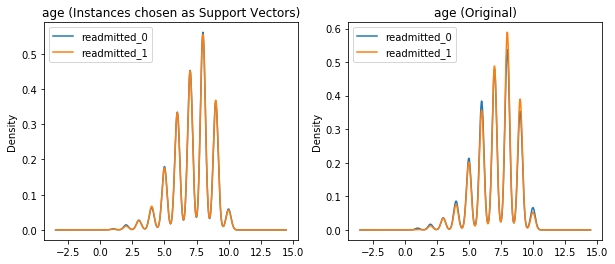

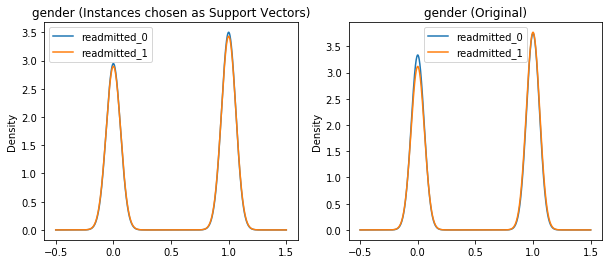

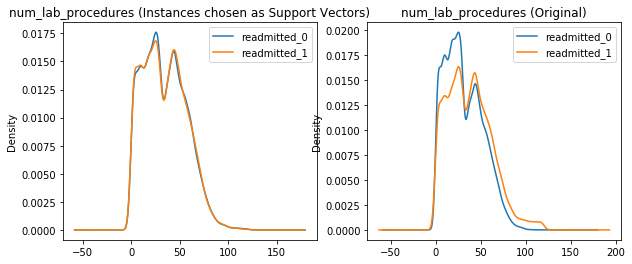

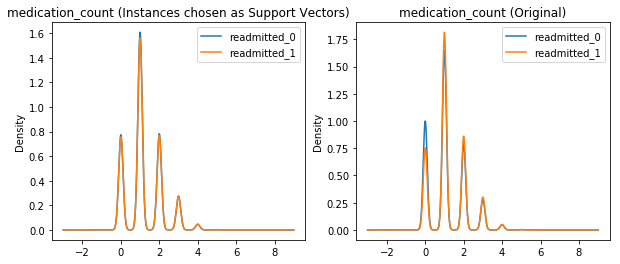

In [60]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['readmitted_tf'])
df_grouped = df_imputed.groupby(['readmitted_tf'])

# plot KDE of Different variables
vars_to_plot = ['age','gender','num_lab_procedures','medication_count']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['readmitted_0','readmitted_1'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['readmitted_0','readmitted_1'])
    plt.title(v+' (Original)')

In [62]:
#try linear kernel, 25 mins run , ACC worse
#more feature engineering can be done to improve the acc

from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled)
#print("Done")

In [63]:
from sklearn import metrics as mt

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.614031639972487
[[9672 1312]
 [6544 2826]]


In [65]:
#reduce dimensionality of data set to 2 feauters.
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_train)
pca_2d = pca.transform(X_train)
#print("Done")

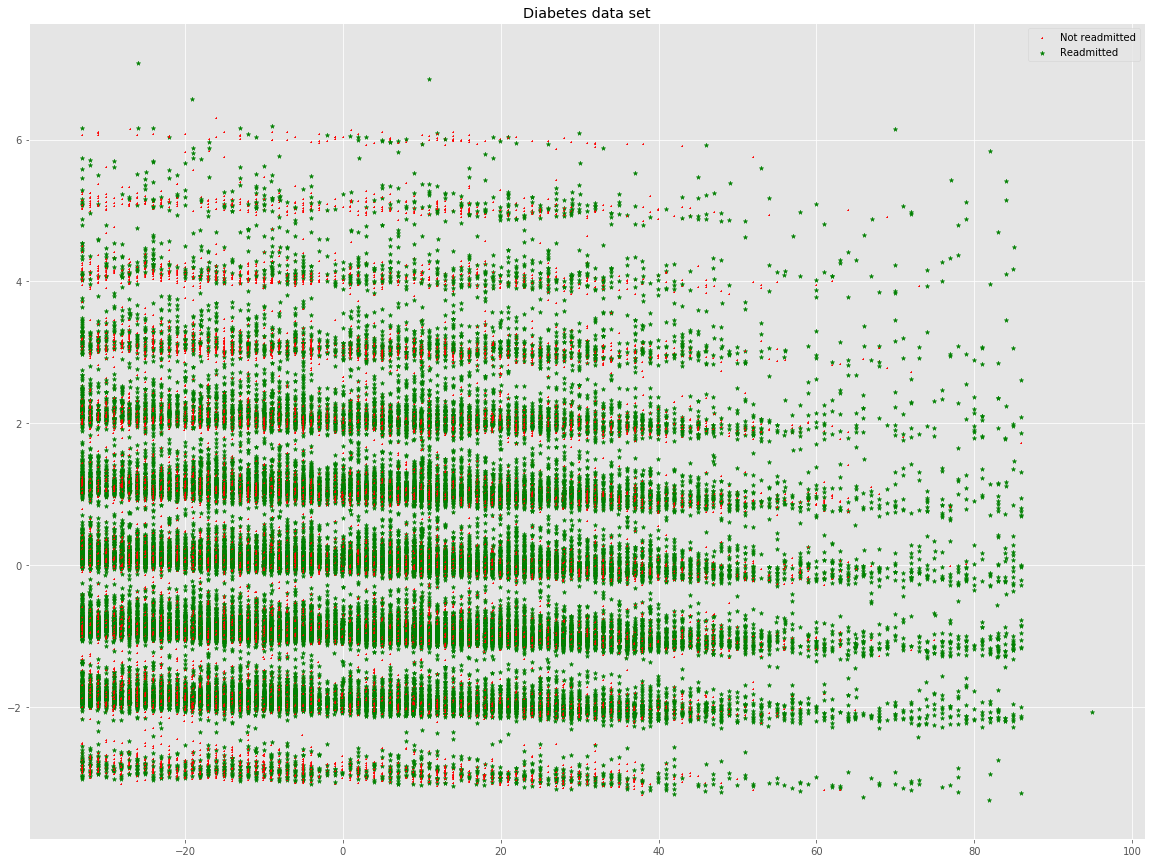

In [66]:
#part of the code was taken from:
#http://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-classifier-in-an-svm-supervised-learning-model/
import pylab as pl
plt.figure(figsize=(20,15))
for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', s=1,marker='+')
    elif y_train[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', s=20,marker='*')
pl.legend([c1, c2], ['Not readmitted', 'Readmitted'])
pl.title('Diabetes data set')
pl.show()

In [67]:
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM:', acc)

NameError: name 'cv' is not defined